In [94]:
import numpy as np
import pandas as pd
from math import ceil
from copy import deepcopy
from pathlib import Path


In [95]:
import pandas as pd
import numpy as np
from math import ceil

# Fechas de inicio de cada escenario (ya las veníamos usando)
SCENARIOS = [
    pd.Timestamp("2023-05-01"),  # Escenario 1
    pd.Timestamp("2024-03-04"),  # Escenario 2
    pd.Timestamp("2025-10-06"),  # Escenario 3
]

len(SCENARIOS), SCENARIOS


(3,
 [Timestamp('2023-05-01 00:00:00'),
  Timestamp('2024-03-04 00:00:00'),
  Timestamp('2025-10-06 00:00:00')])

In [96]:
BASE_DIR   = Path("/content/TESIS2")              # o tu ruta raíz del repo
DATA_RAW   = BASE_DIR / "data" / "raw"
DATA_PROC  = BASE_DIR / "data" / "processed"

# 1) dataset histórico por plato (ya lo usaste para entrenar RF)
CANDIDATE_PATHS = [
    DATA_PROC / "dataset_forecast_diario.csv",
    Path("/content/TESIS2/data/processed/dataset_forecast_diario.csv"),
    Path("/workspace/TESIS2/data/processed/dataset_forecast_diario.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

print("DATA_PATH encontrado:", DATA_PATH)
assert DATA_PATH is not None

df_hist = pd.read_csv(DATA_PATH)
df_hist["fecha"] = pd.to_datetime(df_hist["fecha"])

# 2) otras tablas del datagenerator
receta               = pd.read_csv(DATA_RAW / "receta.csv")
compras              = pd.read_csv(DATA_RAW / "compras.csv", parse_dates=["fecha_registro","fecha_llegada"])
proveedor_x_insumo   = pd.read_csv(DATA_RAW / "proveedor_x_insumo.csv")
inventario_diario_row = pd.read_csv(DATA_RAW / "inventario_diario_row.csv", parse_dates=["fecha_snapshot"])
inventario_mov       = pd.read_csv(DATA_RAW / "inventario_movimientos.csv", parse_dates=["fecha"])


DATA_PATH encontrado: /content/TESIS2/data/processed/dataset_forecast_diario.csv


In [97]:
import pandas as pd
import numpy as np
from pathlib import Path

import xgboost as xgb
# import joblib        # si quieres usar Random Forest u otros modelos sklearn
# from tensorflow.keras.models import load_model  # si usas LSTM, descomenta

# Rutas base (ajusta BASE_DIR según tu estructura)
BASE_DIR = Path("/content/TESIS2").resolve() # FIX: Corrected BASE_DIR path
DATA_PROC = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

print("BASE_DIR:", BASE_DIR)
print("DATA_PROC:", DATA_PROC)
print("MODELS_DIR:", MODELS_DIR)

# Horizonte de forecast (por ejemplo, la próxima semana)
HORIZON_DAYS = 7

def first_monday(year, month):
    first = pd.Timestamp(year=year, month=month, day=1)
    offset = (0 - first.weekday()) % 7  # 0 = lunes
    return first + pd.Timedelta(days=offset)

periodos = [
    {
        "name": "may2023",
        "start": first_monday(2023, 5)
    },
    {
        "name": "mar2024",
        "start": first_monday(2024, 3)
    },
    {
        "name": "oct2025",
        "start": first_monday(2025, 10)
    },
]

for p in periodos:
    p["end"] = p["start"] + pd.Timedelta(days=HORIZON_DAYS - 1)

BASE_DIR: /content/TESIS2
DATA_PROC: /content/TESIS2/data/processed
MODELS_DIR: /content/TESIS2/models


In [98]:
# Dataset usado para entrenar los modelos (histórico diario por plato)
CANDIDATE_PATHS = [
    DATA_PROC / "dataset_forecast_diario.csv",
    Path("/content/TESIS2/data/processed/dataset_forecast_diario.csv"),
    Path("/workspace/TESIS2/data/processed/dataset_forecast_diario.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

print("DATA_PATH encontrado:", DATA_PATH)
assert DATA_PATH is not None, "No se encontró dataset_forecast_diario.csv. Ajusta las rutas si es necesario."

df_hist = pd.read_csv(DATA_PATH)

print("Shape dataset:", df_hist.shape)
df_hist.head()



DATA_PATH encontrado: /content/TESIS2/data/processed/dataset_forecast_diario.csv
Shape dataset: (21530, 46)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2021-01-15,1,13.0,338.0,2021,1,15,4,0,0,...,19.000000,4.123106,19.642857,5.415180,NaN,NaN,-0.433884,-0.900969,0.0,1.0
1,2021-01-16,1,27.0,702.0,2021,1,16,5,1,0,...,18.714286,4.498677,18.428571,4.783212,NaN,NaN,-0.974928,-0.222521,0.0,1.0
2,2021-01-17,1,19.0,494.0,2021,1,17,6,1,0,...,20.714286,4.644505,19.071429,5.298248,NaN,NaN,-0.781831,0.623490,0.0,1.0
3,2021-01-18,1,15.0,390.0,2021,1,18,0,0,0,...,20.571429,4.685337,18.642857,5.017004,NaN,NaN,0.000000,1.000000,0.0,1.0
4,2021-01-19,1,17.0,442.0,2021,1,19,1,0,0,...,20.285714,4.990467,18.285714,5.090392,NaN,NaN,0.781831,0.623490,0.0,1.0


In [116]:
df_hist.head()

,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,dow_cos,mes_sin,mes_cos,year,weekofyear,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start
0,2021-01-15,1,13.0,338.0,2021,1,15,4,0,0,...,-0.900969,0.5,0.866025,2021,2,15,0,0,0,0
1,2021-01-16,1,27.0,702.0,2021,1,16,5,1,0,...,-0.222521,0.5,0.866025,2021,2,16,0,0,0,0
2,2021-01-17,1,19.0,494.0,2021,1,17,6,1,0,...,0.623490,0.5,0.866025,2021,2,17,0,0,0,0
3,2021-01-18,1,15.0,390.0,2021,1,18,0,0,0,...,1.000000,0.5,0.866025,2021,3,18,0,0,0,0
4,2021-01-19,1,17.0,442.0,2021,1,19,1,0,0,...,0.623490,0.5,0.866025,2021,3,19,0,0,0,0


In [117]:
# 1) Construir ventas_reales a partir de df_hist
ventas_reales = (
    df_hist[[DATE_COL, PLATO_COL, TARGET_COL]]
    .rename(columns={
        DATE_COL: "fecha",
        PLATO_COL: "id_plato",
        TARGET_COL: "cantidad"
    })
)

ventas_reales["fecha"] = pd.to_datetime(ventas_reales["fecha"], errors="coerce")

ventas_reales.head()


,fecha,id_plato,cantidad
0,2021-01-15,1,13.0
1,2021-01-16,1,27.0
2,2021-01-17,1,19.0
3,2021-01-18,1,15.0
4,2021-01-19,1,17.0


In [118]:
# Listas de candidatos para flexibilizar nombres de columnas
DATE_COL_CANDS = ["fecha","ds","date","FECHA"]
TARGET_CANDS   = ["cantidad","ventas","ventas_total","venta_total","y","target","ventas_real"]
PLATO_CANDS    = ["id_plato","plato","plato_id","producto","categoria"]

def pick_col(cands, cols):
    cols_lower = [c.lower() for c in cols]
    colmap = {c.lower(): c for c in cols}
    for cand in cands:
        if cand.lower() in cols_lower:
            return colmap[cand.lower()]
    return None

DATE_COL   = pick_col(DATE_COL_CANDS, df_hist.columns)
TARGET_COL = pick_col(TARGET_CANDS, df_hist.columns)
PLATO_COL  = pick_col(PLATO_CANDS, df_hist.columns)

print("DATE_COL  :", DATE_COL)
print("TARGET_COL:", TARGET_COL)
print("PLATO_COL :", PLATO_COL)

assert DATE_COL and TARGET_COL and PLATO_COL, "No se detectaron correctamente las columnas clave"

# Normalizar tipos
df_hist[DATE_COL] = pd.to_datetime(df_hist[DATE_COL], errors="coerce")
df_hist = df_hist.sort_values([PLATO_COL, DATE_COL]).reset_index(drop=True)

df_hist[[DATE_COL, PLATO_COL, TARGET_COL]].head()



DATE_COL  : fecha
TARGET_COL: cantidad
PLATO_COL : plato


,fecha,plato,cantidad
0,2021-01-15,1,13.0
1,2021-01-16,1,27.0
2,2021-01-17,1,19.0
3,2021-01-18,1,15.0
4,2021-01-19,1,17.0


In [119]:
def add_calendar_features(df, date_col):
    """Agrega variables de calendario usadas como regresores."""
    d = df.copy()
    d["year"] = d[date_col].dt.year
    d["weekofyear"] = d[date_col].dt.isocalendar().week.astype(int)
    d["dayofyear"] = d[date_col].dt.dayofyear
    d["is_month_end"] = d[date_col].dt.is_month_end.astype(int)
    d["is_month_start"] = d[date_col].dt.is_month_start.astype(int)
    d["is_quarter_end"] = d[date_col].dt.is_quarter_end.astype(int)
    d["is_quarter_start"] = d[date_col].dt.is_quarter_start.astype(int)

    dow = d[date_col].dt.dayofweek.values
    d["dow"] = dow
    d["dow_sin"] = np.sin(2*np.pi*dow/7.0)
    d["dow_cos"] = np.cos(2*np.pi*dow/7.0)

    mm = d[date_col].dt.month.values
    d["mes"] = mm
    d["mes_sin"] = np.sin(2*np.pi*mm/12.0)
    d["mes_cos"] = np.cos(2*np.pi*mm/12.0)
    return d

def add_lags_rollings(g, target_col, lags=[1,7,14,28], wins=[7,14,28]):
    """Calcula lags y ventanas móviles para una serie por plato."""
    g = g.sort_values(DATE_COL).copy()
    for L in lags:
        g[f"lag_{L}"] = g[target_col].shift(L)
    for W in wins:
        g[f"rolling_mean_{W}"] = g[target_col].shift(1).rolling(W).mean()
        g[f"rolling_std_{W}"]  = g[target_col].shift(1).rolling(W).std()
    return g

# Aplicamos features de calendario al dataset completo
df_hist = add_calendar_features(df_hist, DATE_COL)

# Calculamos lags/rolling por plato
df_hist = df_hist.groupby(PLATO_COL, group_keys=False).apply(
    lambda g: add_lags_rollings(g, TARGET_COL)
)

df_hist.head()


/tmp/ipython-input-783715008.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_hist = df_hist.groupby(PLATO_COL, group_keys=False).apply(


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,dow_cos,mes_sin,mes_cos,year,weekofyear,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start
0,2021-01-15,1,13.0,338.0,2021,1,15,4,0,0,...,-0.900969,0.5,0.866025,2021,2,15,0,0,0,0
1,2021-01-16,1,27.0,702.0,2021,1,16,5,1,0,...,-0.222521,0.5,0.866025,2021,2,16,0,0,0,0
2,2021-01-17,1,19.0,494.0,2021,1,17,6,1,0,...,0.623490,0.5,0.866025,2021,2,17,0,0,0,0
3,2021-01-18,1,15.0,390.0,2021,1,18,0,0,0,...,1.000000,0.5,0.866025,2021,3,18,0,0,0,0
4,2021-01-19,1,17.0,442.0,2021,1,19,1,0,0,...,0.623490,0.5,0.866025,2021,3,19,0,0,0,0


In [101]:
# Vector de features que se usarán como X en los modelos
FEATURE_COLS = [
    "monto_total", "anio", "mes", "dia", "dow", "fin_de_semana", "feriado",
    "lag_1","lag_7","lag_14","lag_28",
    "rolling_mean_7","rolling_mean_14","rolling_mean_28",
    "rolling_std_7","rolling_std_14","rolling_std_28",
    "dow_sin","dow_cos","mes_sin","mes_cos"
]

missing_feats = [c for c in FEATURE_COLS if c not in df_hist.columns]
print("Features faltantes (si hay):", missing_feats)

# Filtramos el dataset a filas donde todos los features estén disponibles
df_model = df_hist.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()

print("Shape modelable:", df_model.shape)
df_model[[DATE_COL, PLATO_COL, TARGET_COL] + FEATURE_COLS].head(3)


Features faltantes (si hay): []
Shape modelable: (21194, 53)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_mean_14,rolling_mean_28,rolling_std_7,rolling_std_14,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
28,2021-02-12,1,18.0,468.0,2021,2,12,4,0,0,...,18.571429,19.214286,18.535714,4.755949,4.440696,4.203016,-0.433884,-0.900969,0.866025,0.5
29,2021-02-13,1,16.0,416.0,2021,2,13,5,1,0,...,19.571429,19.285714,18.714286,3.457222,4.410278,4.062996,-0.974928,-0.222521,0.866025,0.5
30,2021-02-14,1,27.0,702.0,2021,2,14,6,1,0,...,19.000000,18.714286,18.321429,3.696846,4.268463,3.752072,-0.781831,0.623490,0.866025,0.5


In [102]:
def load_model_for_plato(plato_id: int):
    """
    Carga el modelo correspondiente a un plato.
    ADAPTA esta función a tu estructura real:
    - Ejemplo actual: un XGBoost por plato guardado como `models/xgb_poisson/xgb_plato_<id>.json`
    - Si usas otro tipo (Random Forest, LSTM, etc.), ajusta aquí.
    """
    if plato_id <= 9:
        model_path = MODELS_DIR / "xgb_poisson_v2" / f"booster_poisson_plato_{plato_id}.json"
    else: # plato_id 10, 11, 12
        model_path = MODELS_DIR / "xgb_poisson_v2" / f"booster_reg_plato_{plato_id}.json"

    model = xgb.XGBRegressor()
    model.load_model(model_path)
    return model

# Ejemplo (si ya tienes modelos guardados):
# test_model = load_model_for_plato(1)
# test_model

In [103]:
last_date = [
    pd.Timestamp("2023-05-01"),
    pd.Timestamp("2024-03-01"),
    pd.Timestamp("2025-10-01")
]

future_dates_list = [
    pd.date_range(
        start=d + pd.Timedelta(days=1),
        periods=HORIZON_DAYS,
        freq="D"
    )
    for d in last_date
]

future_dates_list


[DatetimeIndex(['2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
                '2023-05-06', '2023-05-07', '2023-05-08'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
                '2024-03-06', '2024-03-07', '2024-03-08'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2025-10-02', '2025-10-03', '2025-10-04', '2025-10-05',
                '2025-10-06', '2025-10-07', '2025-10-08'],
               dtype='datetime64[ns]', freq='D')]

In [104]:
future_dates_list

[DatetimeIndex(['2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
                '2023-05-06', '2023-05-07', '2023-05-08'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
                '2024-03-06', '2024-03-07', '2024-03-08'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2025-10-02', '2025-10-03', '2025-10-04', '2025-10-05',
                '2025-10-06', '2025-10-07', '2025-10-08'],
               dtype='datetime64[ns]', freq='D')]

In [105]:
HORIZON_DAYS = 7

# 3 fechas base (last_date en tu ejemplo)
start_dates = [
    pd.Timestamp("2023-05-01"),
    pd.Timestamp("2024-03-01"),
    pd.Timestamp("2025-10-01")
]

# Creamos future_dates_list (7 días después de cada fecha)
future_dates_list = [
    pd.date_range(
        start=d + pd.Timedelta(days=1),
        periods=HORIZON_DAYS,
        freq="D"
    )
    for d in start_dates
]

# Para guardar los 3 resultados
forecast_xgb_scenarios = []

# ==========================
#   BUCLE PRINCIPAL
# ==========================

for scen_idx, future_dates in enumerate(future_dates_list):

    print(f"\n=== ESCENARIO {scen_idx+1} → {future_dates[0].date()} a {future_dates[-1].date()} ===")

    all_forecasts = []

    for plato_id, g in df_hist.groupby(PLATO_COL):
        g = g.sort_values(DATE_COL).copy()

        # 1) Verificar modelo
        model_path_check = MODELS_DIR / "xgb_poisson_v2" / f"booster_poisson_plato_{plato_id}.json"
        if not model_path_check.exists():
            print(f"⚠️ Modelo no encontrado para plato {plato_id}")
            continue

        model = load_model_for_plato(int(plato_id))
        model_features = model.get_booster().feature_names

        # 2) Copia del histórico del plato
        g_forecast = g.copy()

        # 3) Forecast de 7 días
        for fd in future_dates:

            # Crear fila futura
            new_row = {col: np.nan for col in g_forecast.columns}
            new_row[DATE_COL] = fd
            g_forecast = pd.concat([g_forecast, pd.DataFrame([new_row])], ignore_index=True)

            # Recalcular features
            g_forecast = add_calendar_features(g_forecast, DATE_COL)
            g_forecast = add_lags_rollings(g_forecast, TARGET_COL)

            # Asegurar columnas del modelo
            for col in model_features:
                if col not in g_forecast.columns:
                    g_forecast[col] = 0.0

            # Tomar features del día futuro
            row_fd = g_forecast[g_forecast[DATE_COL] == fd].sort_values(DATE_COL).tail(1)
            X_fd = row_fd[model_features].fillna(0.0)

            # Predicción
            y_hat = model.predict(X_fd)[0]
            g_forecast.loc[g_forecast[DATE_COL] == fd, TARGET_COL] = y_hat

            # Guardar fila predicha
            all_forecasts.append({
                "escenario": scen_idx+1,
                "fecha": fd,
                "id_plato": int(plato_id),
                "demanda_predicha": float(y_hat)
            })


    # Resultado del escenario
    df_scen = pd.DataFrame(all_forecasts).sort_values(["fecha", "id_plato"]).reset_index(drop=True)
    forecast_xgb_scenarios.append(df_scen)
    df_scen.head()
    #print(f"Escenario {scen_idx+1} generado → filas: {df_scen.shape[0]}")



=== ESCENARIO 1 → 2023-05-02 a 2023-05-08 ===


/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

⚠️ Modelo no encontrado para plato 10
⚠️ Modelo no encontrado para plato 11
⚠️ Modelo no encontrado para plato 12

=== ESCENARIO 2 → 2024-03-02 a 2024-03-08 ===


/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

⚠️ Modelo no encontrado para plato 10
⚠️ Modelo no encontrado para plato 11
⚠️ Modelo no encontrado para plato 12

=== ESCENARIO 3 → 2025-10-02 a 2025-10-08 ===


/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

⚠️ Modelo no encontrado para plato 10
⚠️ Modelo no encontrado para plato 11
⚠️ Modelo no encontrado para plato 12


/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1607716893.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

In [106]:
for idx, df_scen in enumerate(forecast_xgb_scenarios, start=1):
    print(f"\n=== HEAD ESCENARIO {idx} ===")
    display(df_scen.head(12))
    #len(df_scen)



=== HEAD ESCENARIO 1 ===


,escenario,fecha,id_plato,demanda_predicha
0,1,2023-05-02,1,22.126406
1,1,2023-05-02,2,18.771564
2,1,2023-05-02,3,12.803515
3,1,2023-05-02,4,17.100370
4,1,2023-05-02,5,13.232828
5,1,2023-05-02,6,11.733130
6,1,2023-05-02,7,9.996265
7,1,2023-05-02,8,8.145488
8,1,2023-05-02,9,7.005704
9,1,2023-05-03,1,25.357061



=== HEAD ESCENARIO 2 ===


,escenario,fecha,id_plato,demanda_predicha
0,2,2024-03-02,1,23.602371
1,2,2024-03-02,2,19.479595
2,2,2024-03-02,3,14.417173
3,2,2024-03-02,4,17.794727
4,2,2024-03-02,5,13.932928
5,2,2024-03-02,6,14.260141
6,2,2024-03-02,7,9.628079
7,2,2024-03-02,8,8.176592
8,2,2024-03-02,9,7.267491
9,2,2024-03-03,1,24.671452



=== HEAD ESCENARIO 3 ===


,escenario,fecha,id_plato,demanda_predicha
0,3,2025-10-02,1,24.922226
1,3,2025-10-02,2,21.370001
2,3,2025-10-02,3,14.816850
3,3,2025-10-02,4,17.619486
4,3,2025-10-02,5,12.476345
5,3,2025-10-02,6,11.314086
6,3,2025-10-02,7,10.457475
7,3,2025-10-02,8,7.719137
8,3,2025-10-02,9,7.538571
9,3,2025-10-03,1,24.239777


In [107]:
forecast_rf_scenarios = []
for scen_idx, future_dates in enumerate(future_dates_list):

    print(f"\n=== ESCENARIO RF {scen_idx+1} → {future_dates[0].date()} a {future_dates[-1].date()} ===")

    all_forecasts = []

    for plato_id, g in df_hist.groupby(PLATO_COL):
        g = g.sort_values(DATE_COL).copy()

        # 1) Validar modelo
        model_path_check = MODELS_DIR / "Random_Forest_Final" / f"plato_{plato_id}.pkl"
        if not model_path_check.exists():
            print(f"⚠️ Modelo RF no encontrado para plato {plato_id}")
            continue

        # Cargar modelo
        model = load_model_for_plato(int(plato_id))

        # RF usa feature_names_in_
        model_features = model.feature_names_in_

        # 2) Copia del histórico
        g_forecast = g.copy()

        # 3) Predecir los 7 días de ese escenario
        for fd in future_dates:

            new_row = {col: np.nan for col in g_forecast.columns}
            new_row[DATE_COL] = fd
            g_forecast = pd.concat([g_forecast, pd.DataFrame([new_row])], ignore_index=True)

            # recalcular features
            g_forecast = add_calendar_features(g_forecast, DATE_COL)
            g_forecast = add_lags_rollings(g_forecast, TARGET_COL)

            # crear columnas faltantes
            for col in model_features:
                if col not in g_forecast.columns:
                    g_forecast[col] = 0.0

            # obtener features del día futuro
            row_fd = g_forecast[g_forecast[DATE_COL] == fd].sort_values(DATE_COL).tail(1)
            X_fd = row_fd[model_features].fillna(0.0)

            # predicción
            y_hat = model.predict(X_fd)[0]
            g_forecast.loc[g_forecast[DATE_COL] == fd, TARGET_COL] = y_hat

            all_forecasts.append({
                "escenario": scen_idx+1,
                "fecha": fd,
                "id_plato": int(plato_id),
                "demanda_predicha": float(y_hat)
            })

    # DataFrame del escenario actual
    df_rf_scen = pd.DataFrame(all_forecasts).sort_values(["fecha","id_plato"]).reset_index(drop=True)
    forecast_rf_scenarios.append(df_rf_scen)

    print(f"Filas escenario RF {scen_idx+1}: {df_rf_scen.shape[0]}")



=== ESCENARIO RF 1 → 2023-05-02 a 2023-05-08 ===


/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

Filas escenario RF 1: 84

=== ESCENARIO RF 2 → 2024-03-02 a 2024-03-08 ===


/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

Filas escenario RF 2: 84

=== ESCENARIO RF 3 → 2025-10-02 a 2025-10-08 ===


/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

Filas escenario RF 3: 84


/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = row_fd[model_features].fillna(0.0)
/tmp/ipython-input-1891431536.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fd = 

In [108]:

for idx, df_scen in enumerate(forecast_rf_scenarios, start=1):
    print(f"\n=== HEAD ESCENARIO RF {idx} ===")
    display(df_scen.head())



=== HEAD ESCENARIO RF 1 ===


,escenario,fecha,id_plato,demanda_predicha
0,1,2023-05-02,1,22.126406
1,1,2023-05-02,2,18.771564
2,1,2023-05-02,3,12.803515
3,1,2023-05-02,4,17.100370
4,1,2023-05-02,5,13.232828



=== HEAD ESCENARIO RF 2 ===


,escenario,fecha,id_plato,demanda_predicha
0,2,2024-03-02,1,23.602371
1,2,2024-03-02,2,19.479595
2,2,2024-03-02,3,14.417173
3,2,2024-03-02,4,17.794727
4,2,2024-03-02,5,13.932928



=== HEAD ESCENARIO RF 3 ===


,escenario,fecha,id_plato,demanda_predicha
0,3,2025-10-02,1,24.922226
1,3,2025-10-02,2,21.370001
2,3,2025-10-02,3,14.816850
3,3,2025-10-02,4,17.619486
4,3,2025-10-02,5,12.476345


In [109]:
forecast_rf_scenarios[0].head()

,escenario,fecha,id_plato,demanda_predicha
0,1,2023-05-02,1,22.126406
1,1,2023-05-02,2,18.771564
2,1,2023-05-02,3,12.803515
3,1,2023-05-02,4,17.100370
4,1,2023-05-02,5,13.232828


In [110]:
# Asegurar tipos de fecha en compras
compras["fecha_registro"] = pd.to_datetime(compras["fecha_registro"], errors="coerce")
compras["fecha_llegada"] = pd.to_datetime(compras["fecha_llegada"], errors="coerce")

# Lead time real (días)
compras["lead_time_real"] = (compras["fecha_llegada"] - compras["fecha_registro"]).dt.days

compras_validas = compras.dropna(
    subset=["lead_time_real", "id_insumo", "id_proveedor"]
)

leadtime_hist = (
    compras_validas
    .groupby(["id_insumo", "id_proveedor"], as_index=False)["lead_time_real"]
    .mean()
    .rename(columns={"lead_time_real": "lead_time"})
)

leadtime_hist["lead_time"] = leadtime_hist["lead_time"].clip(lower=1).astype(int)

display(leadtime_hist.head())

# ----------------------------
# Matriz proveedor_x_insumo
# ----------------------------
assert {"id_insumo", "id_proveedor"}.issubset(proveedor_x_insumo.columns)

if "moq" not in proveedor_x_insumo.columns:
    proveedor_x_insumo["moq"] = 0.0
if "multiplo_pedido" not in proveedor_x_insumo.columns:
    proveedor_x_insumo["multiplo_pedido"] = 1.0

pref_prov = proveedor_x_insumo.merge(
    leadtime_hist,
    on=["id_insumo", "id_proveedor"],
    how="left"
)

pref_prov["lead_time"] = pref_prov["lead_time"].fillna(2).astype(int)

# Elegimos proveedor con menor lead_time por insumo
pref_prov = (
    pref_prov
    .sort_values(["id_insumo", "lead_time"])
    .groupby("id_insumo", as_index=False)
    .first()
)

pref_prov = pref_prov.rename(columns={
    "id_proveedor": "id_proveedor_pref",
    "moq": "moq_pref",
    "multiplo_pedido": "multiplo_pref"
})

pref_prov = pref_prov[[
    "id_insumo",
    "id_proveedor_pref",
    "lead_time",
    "moq_pref",
    "multiplo_pref"
]]

display(pref_prov.head())


,id_insumo,id_proveedor,lead_time
0,101,1.0,4
1,101,3.0,7
2,101,5.0,6
3,101,6.0,2
4,101,7.0,5


,id_insumo,id_proveedor_pref,lead_time,moq_pref,multiplo_pref
0,101,6,2,0.0,1.0
1,102,2,2,0.0,1.0
2,103,4,3,0.0,1.0
3,104,4,2,0.0,1.0
4,105,1,2,0.0,1.0


In [111]:
resultados_plan = []  # lista: plan de compras por escenario
resultados_inv  = []  # lista: inventario proyectado por escenario

for idx, start_date in enumerate(SCENARIOS):
    esc = idx + 1
    print(f"\n======================")
    print(f" Escenario RF {esc} – inicio {start_date.date()}")
    print(f"======================")

    # ------------------------
    # 2.1. Forecast de platos
    # ------------------------
    forecast_plato = forecast_rf_scenarios[idx].copy()
    forecast_plato["fecha"] = pd.to_datetime(forecast_plato["fecha"], errors="coerce")
    forecast_plato["id_plato"] = forecast_plato["id_plato"].astype(int)

    PLANNING_START_DATE = forecast_plato["fecha"].min()
    PLANNING_END_DATE   = forecast_plato["fecha"].max()

    print("Ventana de planificación:",
          PLANNING_START_DATE.date(), "→", PLANNING_END_DATE.date())

    # ------------------------
    # 2.2. Demanda de insumos
    # ------------------------
    assert {"id_plato", "id_insumo"}.issubset(receta.columns)

    receta_use = receta.copy()
    if "cantidad_insumo" not in receta_use.columns:
        cand = [c for c in receta_use.columns if "cant" in c.lower()]
        receta_use = receta_use.rename(columns={cand[0]: "cantidad_insumo"})

    receta_use["id_plato"]  = receta_use["id_plato"].astype(int)
    receta_use["id_insumo"] = receta_use["id_insumo"].astype(int)

    df_req = forecast_plato.merge(receta_use, on="id_plato", how="left")
    df_req["demanda_insumo"] = df_req["demanda_predicha"] * df_req["cantidad_insumo"]

    req_insumo = (
        df_req
        .groupby(["fecha", "id_insumo"], as_index=False)["demanda_insumo"]
        .sum()
    )

    print("req_insumo shape:", req_insumo.shape)
    # display(req_insumo.head())

    # ------------------------
    # 2.3. Inventario inicial (foto en inventario_diario_row)
    # ------------------------
    inv_ref = (
        inventario_diario_row[
            inventario_diario_row["fecha_snapshot"] == PLANNING_START_DATE
        ]
        .groupby("id_insumo", as_index=False)["stock_utilizable"]
        .sum()
        .rename(columns={"stock_utilizable": "stock_on_hand"})
    )

    print("Inventario de referencia:", inv_ref.shape)
    # display(inv_ref.head())

    # Compras ya colocadas en el sistema que llegan después del inicio
    compras_futuras = compras[
        (compras["fecha_registro"] < PLANNING_START_DATE) &
        (compras["fecha_llegada"]  >= PLANNING_START_DATE) &
        (compras["fecha_llegada"]  <= PLANNING_END_DATE)
    ].copy()


    # ------------------------
    # 2.4. Parámetros de inventario (s, S)
    # ------------------------
    # A partir de req_insumo (demanda de insumos del ESCENARIO actual)

    stats_insumo = (
        req_insumo.groupby("id_insumo")["demanda_insumo"]
        .agg(["mean", "std"])
        .reset_index()
        .rename(columns={"mean": "mu_dia", "std": "sigma_dia"})
    )

    # Unimos con info de proveedor (lead_time, moq, múltiplos)
    params_insumo = stats_insumo.merge(pref_prov, on="id_insumo", how="left")

    # Defaults robustos
    params_insumo["sigma_dia"]      = params_insumo["sigma_dia"].fillna(0.0)
    params_insumo["lead_time"]      = params_insumo["lead_time"].fillna(2).astype(int)
    params_insumo["moq_pref"]       = params_insumo["moq_pref"].fillna(0.0)
    params_insumo["multiplo_pref"]  = params_insumo["multiplo_pref"].replace(0, 1.0)

    # ⚙️ Parámetros base del modelo
    SERVICE_Z   = 0.0   # sin buffer estadístico, súper agresivo
    SAFETY_DAYS = 0     # sin días extra de seguridad
    FACTOR_S    = 1.05  # S ≈ 1 día más de demanda

    # 💥 Factor para “aplastar” s y S (ajústalo 0.3, 0.2, etc.)
    SHRINK_FACTOR = 0.3

    # Demanda esperada durante el lead time
    params_insumo["demanda_LT"] = params_insumo["mu_dia"] * (
        params_insumo["lead_time"] + SAFETY_DAYS
    )

    # Buffer (casi 0 porque SERVICE_Z=0)
    params_insumo["buffer"] = (
        SERVICE_Z * params_insumo["sigma_dia"] * np.sqrt(params_insumo["lead_time"])
    )

    # s y S base (antes de achicar)
    params_insumo["s_base"] = params_insumo["demanda_LT"] + params_insumo["buffer"]
    params_insumo["S_base"] = FACTOR_S * params_insumo["demanda_LT"] + params_insumo["buffer"]

    # ✅ s y S FINALES (MUY BAJOS)
    params_insumo["s"] = params_insumo["s_base"] * SHRINK_FACTOR
    params_insumo["S"] = params_insumo["S_base"] * SHRINK_FACTOR

    # Aseguramos que S > s siempre
    params_insumo["S"] = np.maximum(params_insumo["S"], params_insumo["s"] + 1e-6)

    # (opcional) ver top insumos
    top_insumos = (
        params_insumo
        .sort_values("mu_dia", ascending=False)
        .head(10)[["id_insumo", "mu_dia", "sigma_dia", "lead_time", "s", "S"]]
    )

    print(f"\n[Escenario {esc}] Parámetros (s, S) – Top 10 insumos por demanda")
    display(top_insumos)


    # ------------------------
    # 2.5. Estado inicial por insumo
    # ------------------------
    # capacidad_insumo es opcional; si no la tienes, esto queda vacío
    cap_map = (
        dict(zip(capacidad_insumo["id_insumo"], capacidad_insumo["capacidad_maxima"]))
        if "capacidad_insumo" in globals()
        else {}
    )

    inv_map    = dict(zip(inv_ref["id_insumo"], inv_ref["stock_on_hand"]))
    params_map = params_insumo.set_index("id_insumo").to_dict(orient="index")

    state = {}

    for insumo_id in req_insumo["id_insumo"].unique():
        stock0 = inv_map.get(insumo_id, 0.0)
        p      = params_map.get(insumo_id, {})

        # Órdenes ya registradas que llegarán en el futuro
        on_order = []
        if insumo_id in compras_futuras["id_insumo"].unique():
            sub = compras_futuras[compras_futuras["id_insumo"] == insumo_id]
            for _, r in sub.iterrows():
                on_order.append({
                    "fecha_entrega": r["fecha_llegada"].date(),
                    "cantidad": float(r["cantidad_entrada"]),
                    "id_proveedor": r.get("id_proveedor"),
                    "es_historica": True
                })

        state[insumo_id] = {
            "stock_on_hand": stock0,
            "on_order": on_order,
            "s": p.get("s", 0.0),
            "S": p.get("S", 0.0),
            "lead_time": p.get("lead_time", 2),
            "moq": p.get("moq_pref", 0.0),
            "multiplo": p.get("multiplo_pref", 1.0),
            "id_proveedor_pref": p.get("id_proveedor_pref"),
            "capacidad_max": cap_map.get(insumo_id)
        }

    print("Insumos en estado:", len(state))

    # ------------------------
    # 2.6. Simulación día a día (modelo (s, S))
    # ------------------------
    req_dict = {
        (r["id_insumo"], r["fecha"].date()): r["demanda_insumo"]
        for _, r in req_insumo.iterrows()
    }

    date_range = pd.date_range(PLANNING_START_DATE, PLANNING_END_DATE, freq="D")

    plan_rows   = []
    inv_log_rows = []
    forecast_file = f"RF_escenario_{esc}"

    for current_date in date_range:
        d = current_date.date()

        for iid, st in state.items():

            # 1. Recibir órdenes que llegan hoy
            new_orders = []
            for o in st["on_order"]:
                if o["fecha_entrega"] == d:
                    st["stock_on_hand"] += o["cantidad"]
                else:
                    new_orders.append(o)
            st["on_order"] = new_orders

            # 2. Consumo del día
            demand = req_dict.get((iid, d), 0.0)
            st["stock_on_hand"] = max(st["stock_on_hand"] - demand, 0.0)

            # 3. Posición de inventario
            pos = st["stock_on_hand"] + sum(o["cantidad"] for o in st["on_order"])
            s   = st["s"]
            S   = st["S"]
            cap = st["capacidad_max"]
            Q   = 0.0

            # 4. Política (s, S)
            if pos < s:
                Q = S - pos

                if st["moq"] > 0:
                    Q = max(Q, st["moq"])

                if st["multiplo"] > 1:
                    Q = ceil(Q / st["multiplo"]) * st["multiplo"]

                if cap is not None:
                    already = st["stock_on_hand"] + sum(o["cantidad"] for o in st["on_order"])
                    espacio = cap - already
                    Q = max(0.0, min(Q, espacio))

                if Q > 0:
                    fecha_entrega = (current_date + pd.Timedelta(days=st["lead_time"])).date()
                    prov = st["id_proveedor_pref"]

                    st["on_order"].append({
                        "fecha_entrega": fecha_entrega,
                        "cantidad": Q,
                        "id_proveedor": prov,
                        "es_historica": False
                    })

                    plan_rows.append({
                        "id_insumo": iid,
                        "id_proveedor": prov,
                        "fecha_orden": d,
                        "fecha_entrega": fecha_entrega,
                        "cantidad": Q,
                        "motivo": "reposición_sS",
                        "forecast_file": forecast_file,
                        "escenario": esc,
                    })

            inv_log_rows.append({
                "fecha": d,
                "id_insumo": iid,
                "stock_on_hand": st["stock_on_hand"],
                "posicion_inventario": st["stock_on_hand"] + sum(o["cantidad"] for o in st["on_order"]),
                "demanda_dia": demand,
                "Q_ordenado": Q,
                "capacidad_max": cap,
                "escenario": esc
            })

    plan_df = pd.DataFrame(plan_rows)
    inv_df  = pd.DataFrame(inv_log_rows)

    print(f" → Escenario {esc}: plan_compras={plan_df.shape}, inv_log={inv_df.shape}")

    resultados_plan.append(plan_df)
    resultados_inv.append(inv_df)



 Escenario RF 1 – inicio 2023-05-01
Ventana de planificación: 2023-05-02 → 2023-05-08
req_insumo shape: (147, 3)
Inventario de referencia: (22, 2)

[Escenario 1] Parámetros (s, S) – Top 10 insumos por demanda


,id_insumo,mu_dia,sigma_dia,lead_time,s,S
10,111,17.566998,0.580741,2,10.540199,11.067208
9,110,8.546870,0.316055,2,5.128122,5.384528
3,104,7.908274,0.452532,2,4.744964,4.982212
0,101,7.483656,0.297548,2,4.490194,4.714703
1,102,5.160237,0.254356,2,3.096142,3.250949
4,105,4.800497,0.283868,2,2.880298,3.024313
6,107,3.427885,0.093648,5,5.141827,5.398919
11,112,3.354764,0.153140,2,2.012858,2.113501
12,113,2.687686,0.166598,2,1.612612,1.693242
5,106,1.977068,0.113133,4,2.372482,2.491106


Insumos en estado: 21
 → Escenario 1: plan_compras=(46, 8), inv_log=(147, 8)

 Escenario RF 2 – inicio 2024-03-04
Ventana de planificación: 2024-03-02 → 2024-03-08
req_insumo shape: (147, 3)
Inventario de referencia: (22, 2)

[Escenario 2] Parámetros (s, S) – Top 10 insumos por demanda


,id_insumo,mu_dia,sigma_dia,lead_time,s,S
10,111,17.512701,0.640532,2,10.507621,11.033002
9,110,8.520717,0.488763,2,5.112430,5.368052
3,104,7.769098,0.529825,2,4.661459,4.894532
0,101,7.464847,0.269115,2,4.478908,4.702853
1,102,5.152218,0.213232,2,3.091331,3.245897
4,105,4.736400,0.309038,2,2.841840,2.983932
6,107,3.427888,0.125055,5,5.141831,5.398923
11,112,3.407108,0.259619,2,2.044265,2.146478
12,113,2.618520,0.104073,2,1.571112,1.649668
5,106,1.942274,0.132456,4,2.330729,2.447266


Insumos en estado: 21
 → Escenario 2: plan_compras=(45, 8), inv_log=(147, 8)

 Escenario RF 3 – inicio 2025-10-06
Ventana de planificación: 2025-10-02 → 2025-10-08
req_insumo shape: (147, 3)
Inventario de referencia: (22, 2)

[Escenario 3] Parámetros (s, S) – Top 10 insumos por demanda


,id_insumo,mu_dia,sigma_dia,lead_time,s,S
10,111,18.069580,1.211179,2,10.841748,11.383835
9,110,8.807484,0.778915,2,5.284491,5.548715
3,104,8.094809,0.544457,2,4.856885,5.099729
0,101,7.901817,0.710125,2,4.741090,4.978145
1,102,5.489597,0.301387,2,3.293758,3.458446
4,105,4.971565,0.287398,2,2.982939,3.132086
6,107,3.661379,0.060858,5,5.492068,5.766671
11,112,3.408838,0.273334,2,2.045303,2.147568
12,113,2.713291,0.231152,2,1.627975,1.709374
5,106,2.023702,0.136114,4,2.428443,2.549865


Insumos en estado: 21
 → Escenario 3: plan_compras=(72, 8), inv_log=(147, 8)


In [113]:
from IPython.display import display

for idx, start_date in enumerate(SCENARIOS):
    esc = idx + 1
    print("\n==============================")
    print(f" ESCENARIO RF {esc} – inicio {start_date.date()}")
    print("==============================")

    plan_df = resultados_plan[idx].copy()
    inv_df  = resultados_inv[idx].copy()

    # Aseguramos tipos de fecha
    if "fecha_orden" in plan_df.columns:
        plan_df["fecha_orden"] = pd.to_datetime(plan_df["fecha_orden"], errors="coerce")
    if "fecha" in inv_df.columns:
        inv_df["fecha"] = pd.to_datetime(inv_df["fecha"], errors="coerce")

    # --- ÓRDENES DE COMPRA ---
    print(f"\n[Escenario {esc}] Órdenes de compra generadas: {len(plan_df)}")
    if len(plan_df) > 0:
        print("Head de órdenes de compra:")
        display(
            plan_df[[
                "fecha_orden",
                "fecha_entrega",
                "id_insumo",
                "cantidad",
                "id_proveedor",
                "motivo"
            ]].head(10)
        )
    else:
        print("⚠️ No se generaron órdenes en este escenario.")

    # --- INVENTARIO SIMULADO ---
    print(f"\n[Escenario {esc}] Inventario simulado (muestra):")
    if len(inv_df) > 0:
        display(
            inv_df[[
                "fecha",
                "id_insumo",
                "stock_on_hand",
                "posicion_inventario",
                "demanda_dia",
                "Q_ordenado"
            ]].head(10)
        )
    else:
        print("⚠️ No hay registros de inventario simulado.")



 ESCENARIO RF 1 – inicio 2023-05-01

[Escenario 1] Órdenes de compra generadas: 46
Head de órdenes de compra:


,fecha_orden,fecha_entrega,id_insumo,cantidad,id_proveedor,motivo
0,2023-05-02,2023-05-04,104,4.982212,4,reposición_sS
1,2023-05-02,2023-05-04,110,5.384528,7,reposición_sS
2,2023-05-02,2023-05-04,111,11.067208,7,reposición_sS
3,2023-05-02,2023-05-04,115,0.416453,6,reposición_sS
4,2023-05-03,2023-05-05,113,0.341892,4,reposición_sS
5,2023-05-04,2023-05-06,102,1.979998,2,reposición_sS
6,2023-05-04,2023-05-06,104,4.982212,4,reposición_sS
7,2023-05-04,2023-05-06,105,2.443720,1,reposición_sS
8,2023-05-04,2023-05-06,110,5.384528,7,reposición_sS
9,2023-05-04,2023-05-06,111,11.067208,7,reposición_sS



[Escenario 1] Inventario simulado (muestra):


,fecha,id_insumo,stock_on_hand,posicion_inventario,demanda_dia,Q_ordenado
0,2023-05-02,101,0.000000,26.691947,7.211253,0.000000
1,2023-05-02,102,11.939522,11.939522,4.860216,0.000000
2,2023-05-02,103,19.210355,19.210355,1.397197,0.000000
3,2023-05-02,104,0.000000,4.982212,7.508626,4.982212
4,2023-05-02,105,4.334235,10.176558,4.593237,0.000000
5,2023-05-02,106,7.849142,7.849142,1.877156,0.000000
6,2023-05-02,107,7.015297,28.052322,3.280770,0.000000
7,2023-05-02,108,3.092156,3.092156,0.640176,0.000000
8,2023-05-02,109,126.526784,126.526784,0.628185,0.000000
9,2023-05-02,110,0.000000,5.384528,8.396644,5.384528



 ESCENARIO RF 2 – inicio 2024-03-04

[Escenario 2] Órdenes de compra generadas: 45
Head de órdenes de compra:


,fecha_orden,fecha_entrega,id_insumo,cantidad,id_proveedor,motivo
0,2024-03-02,2024-03-05,103,1.412290,4,reposición_sS
1,2024-03-02,2024-03-05,114,0.376308,4,reposición_sS
2,2024-03-03,2024-03-05,111,4.735603,7,reposición_sS
3,2024-03-03,2024-03-06,114,0.366042,4,reposición_sS
4,2024-03-04,2024-03-06,111,3.151870,7,reposición_sS
5,2024-03-04,2024-03-06,115,0.140849,6,reposición_sS
6,2024-03-05,2024-03-08,103,1.412290,4,reposición_sS
7,2024-03-05,2024-03-07,104,2.083544,4,reposición_sS
8,2024-03-05,2024-03-09,106,0.244099,8,reposición_sS
9,2024-03-05,2024-03-07,110,5.368052,7,reposición_sS



[Escenario 2] Inventario simulado (muestra):


,fecha,id_insumo,stock_on_hand,posicion_inventario,demanda_dia,Q_ordenado
0,2024-03-02,101,9.589677,21.863545,7.424238,0.00000
1,2024-03-02,102,12.612524,24.875124,5.139204,0.00000
2,2024-03-02,103,0.000000,1.412290,1.520782,1.41229
3,2024-03-02,104,26.596931,26.596931,7.791838,0.00000
4,2024-03-02,105,5.053349,25.242464,4.811012,0.00000
5,2024-03-02,106,0.000000,7.626911,1.947960,0.00000
6,2024-03-02,107,13.232715,20.009620,3.642887,0.00000
7,2024-03-02,108,0.000000,1.831611,0.720859,0.00000
8,2024-03-02,109,22.369392,22.369392,0.703556,0.00000
9,2024-03-02,110,14.067814,22.808799,9.060259,0.00000



 ESCENARIO RF 3 – inicio 2025-10-06

[Escenario 3] Órdenes de compra generadas: 72
Head de órdenes de compra:


,fecha_orden,fecha_entrega,id_insumo,cantidad,id_proveedor,motivo
0,2025-10-02,2025-10-05,103,0.736605,4,reposición_sS
1,2025-10-02,2025-10-04,105,0.886777,1,reposición_sS
2,2025-10-02,2025-10-04,110,1.955561,7,reposición_sS
3,2025-10-02,2025-10-04,119,0.019284,3,reposición_sS
4,2025-10-03,2025-10-05,101,3.284369,6,reposición_sS
5,2025-10-03,2025-10-06,103,0.773660,4,reposición_sS
6,2025-10-03,2025-10-05,105,0.841296,1,reposición_sS
7,2025-10-03,2025-10-05,110,0.534391,7,reposición_sS
8,2025-10-03,2025-10-06,114,0.545915,4,reposición_sS
9,2025-10-03,2025-10-05,115,0.432660,6,reposición_sS



[Escenario 3] Inventario simulado (muestra):


,fecha,id_insumo,stock_on_hand,posicion_inventario,demanda_dia,Q_ordenado
0,2025-10-02,101,6.256741,9.223334,7.703024,0.000000
1,2025-10-02,102,12.258287,28.699400,5.396819,0.000000
2,2025-10-02,103,0.773660,1.510265,1.589563,0.736605
3,2025-10-02,104,2.708371,23.068935,8.548000,0.000000
4,2025-10-02,105,0.841296,3.132086,5.154992,0.886777
5,2025-10-02,106,7.915366,11.586575,2.137000,0.000000
6,2025-10-02,107,7.937933,16.353342,3.694767,0.000000
7,2025-10-02,108,0.303769,1.198792,0.740842,0.000000
8,2025-10-02,109,0.000000,2.976982,0.628662,0.000000
9,2025-10-02,110,0.000000,5.548715,8.359523,1.955561


In [122]:
resumen_escenarios = []

for idx, start_date in enumerate(SCENARIOS):
    esc = idx + 1
    inv_df  = resultados_inv[idx].copy()
    plan_df = resultados_plan[idx].copy()

    # Fin del horizonte según la simulación
    end_date = pd.to_datetime(inv_df["fecha"], errors="coerce").max()

    # --- DEMANDA REAL (ventas) ---
    mask_v = (ventas_reales["fecha"] >= start_date) & (ventas_reales["fecha"] <= end_date)
    demanda_real_total = ventas_reales.loc[mask_v, "cantidad"].sum()

    # --- COMPRAS REALES ---
    mask_c = (
        (compras["fecha_registro"] >= start_date) &
        (compras["fecha_registro"] <= end_date)
    )
    compras_real_total = compras.loc[mask_c, "cantidad_entrada"].sum()

    # --- COMPRAS PLANIFICADAS (modelo) ---
    compras_plan_total = plan_df["cantidad"].sum()

    resumen_escenarios.append({
        "escenario": esc,
        "periodo": f"{start_date.date()} → {end_date.date()}",
        "demanda_real_total": demanda_real_total,
        "compras_real_total": compras_real_total,
        "compras_plan_total": compras_plan_total,
    })

resumen_df = pd.DataFrame(resumen_escenarios)
print("\n==== RESUMEN GLOBAL POR ESCENARIO ====")
display(resumen_df)



==== RESUMEN GLOBAL POR ESCENARIO ====


,escenario,periodo,demanda_real_total,compras_real_total,compras_plan_total
0,1,2023-05-01 → 2023-05-08,1138.0,311.171525,128.147560
1,2,2024-03-04 → 2024-03-08,666.0,109.764405,85.750532
2,3,2025-10-06 → 2025-10-08,450.0,101.131236,117.261553


In [123]:
from copy import deepcopy

compras_todos = []

for idx, start_date in enumerate(SCENARIOS):
    esc = idx + 1
    inv_df  = resultados_inv[idx].copy()
    plan_df = resultados_plan[idx].copy()
    end_date = pd.to_datetime(inv_df["fecha"], errors="coerce").max()

    # PLANIFICADAS
    plan = deepcopy(plan_df)
    plan["fecha_orden"] = pd.to_datetime(plan["fecha_orden"], errors="coerce")
    plan = plan[
        (plan["fecha_orden"] >= start_date) &
        (plan["fecha_orden"] <= end_date)
    ].copy()

    plan_agg = (
        plan.groupby(["fecha_orden", "id_insumo"], as_index=False)["cantidad"]
        .sum()
        .rename(columns={
            "fecha_orden": "fecha_orden_plan",
            "cantidad": "cantidad_plan"
        })
    )

    # REALES
    compras_real = compras[
        (compras["fecha_registro"] >= start_date) &
        (compras["fecha_registro"] <= end_date)
    ].copy()
    compras_real["fecha_registro"] = pd.to_datetime(compras_real["fecha_registro"], errors="coerce")
    compras_real = compras_real.rename(columns={
        "fecha_registro": "fecha_orden_real",
        "cantidad_entrada": "cantidad_real"
    })

    compras_real_agg = (
        compras_real.groupby(["fecha_orden_real", "id_insumo"], as_index=False)["cantidad_real"]
        .sum()
    )

    # MERGE REAL vs PLAN
    compras_merge = plan_agg.merge(
        compras_real_agg,
        left_on=["fecha_orden_plan", "id_insumo"],
        right_on=["fecha_orden_real", "id_insumo"],
        how="outer"
    )

    compras_merge["cantidad_plan"] = compras_merge["cantidad_plan"].fillna(0.0)
    compras_merge["cantidad_real"] = compras_merge["cantidad_real"].fillna(0.0)
    compras_merge["escenario"] = esc

    compras_todos.append(compras_merge)

# Tabla final con todos los escenarios
compras_todos_df = pd.concat(compras_todos, ignore_index=True)

print("\n▶ Compras REALES vs PLAN (head)")
display(
    compras_todos_df[[
        "escenario",
        "fecha_orden_plan",
        "id_insumo",
        "cantidad_plan",
        "fecha_orden_real",
        "cantidad_real",
    ]].head(20)
)



▶ Compras REALES vs PLAN (head)


,escenario,fecha_orden_plan,id_insumo,cantidad_plan,fecha_orden_real,cantidad_real
0,1,NaT,101,0.000000,2023-05-01,5.499924
1,1,NaT,105,0.000000,2023-05-01,6.425121
2,1,NaT,107,0.000000,2023-05-01,4.624938
3,1,NaT,112,0.000000,2023-05-01,4.425405
4,1,NaT,117,0.000000,2023-05-01,2.006008
5,1,NaT,101,0.000000,2023-05-02,7.779814
6,1,2023-05-02,104,4.982212,2023-05-02,4.734672
7,1,NaT,105,0.000000,2023-05-02,2.458949
8,1,2023-05-02,110,5.384528,NaT,0.000000
9,1,2023-05-02,111,11.067208,2023-05-02,12.696260


Columnas df_hist: ['fecha', 'plato', 'cantidad', 'monto_total', 'anio', 'mes', 'dia', 'dow', 'fin_de_semana', 'feriado', 'evento_Ano_Nuevo', 'evento_Viernes_Santo', 'evento_Sabado_Santo', 'evento_Dia_del_Trabajador', 'evento_Dia_del_Pollo_a_la_Brasa', 'evento_San_Pedro_y_San_Pablo', 'evento_Fiestas_Patrias_1', 'evento_Fiestas_Patrias_2', 'evento_Santa_Rosa_de_Lima', 'evento_Combate_de_Angamos', 'evento_Dia_de_Todos_los_Santos', 'evento_Inmaculada_Concepcion', 'evento_Navidad', 'evento_Dia_del_Padre', 'evento_Dia_del_Ceviche', 'temp_invierno', 'temp_otono', 'temp_primavera', 'temp_verano', 'clima_Lluvioso', 'clima_Nublado', 'clima_Soleado', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28', 'dow_sin', 'dow_cos', 'mes_sin', 'mes_cos', 'year', 'weekofyear', 'dayofyear', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start']
Preview ventas_reales:


,fecha,id_plato,venta_real
0,2021-01-15,1,13.0
1,2021-01-16,1,27.0
2,2021-01-17,1,19.0
3,2021-01-18,1,15.0
4,2021-01-19,1,17.0



=== Escenario 1 (2023-05-01 → 2023-05-08) ===
  Demanda real total  : 1138.00
  Compras reales total: 311.17
  Compras plan total  : 128.15
  Ratio real (C/D)    : 0.273
  Ratio plan (C/D)    : 0.113
  Ahorro % plan vs real: 58.82 %

=== Escenario 2 (2024-03-04 → 2024-03-08) ===
  Demanda real total  : 666.00
  Compras reales total: 109.76
  Compras plan total  : 78.86
  Ratio real (C/D)    : 0.165
  Ratio plan (C/D)    : 0.118
  Ahorro % plan vs real: 28.15 %

=== Escenario 3 (2025-10-06 → 2025-10-08) ===
  Demanda real total  : 450.00
  Compras reales total: 101.13
  Compras plan total  : 73.35
  Ratio real (C/D)    : 0.225
  Ratio plan (C/D)    : 0.163
  Ahorro % plan vs real: 27.47 %

=== RESUMEN OVERSTOCK (TOTAL POR ESCENARIO) ===


,escenario,start_date,end_date,demanda_real_total,compra_real_total,compra_plan_total,ratio_real,ratio_plan,ahorro_porcentual
0,1,2023-05-01,2023-05-08,1138.0,311.171525,128.147560,0.273437,0.112608,58.817710
1,2,2024-03-04,2024-03-08,666.0,109.764405,78.860288,0.164811,0.118409,28.154953
2,3,2025-10-06,2025-10-08,450.0,101.131236,73.348297,0.224736,0.162996,27.472165


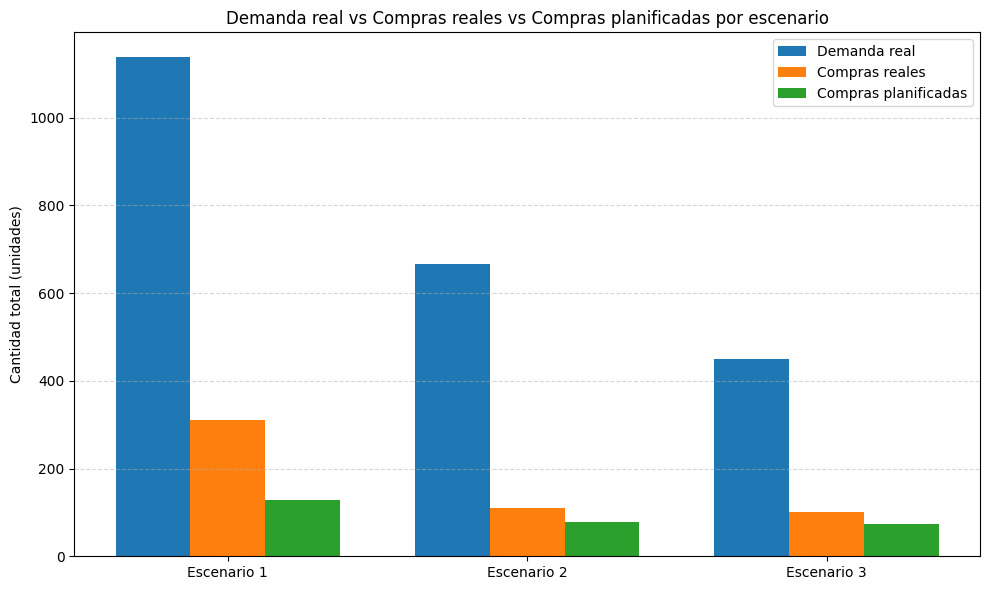

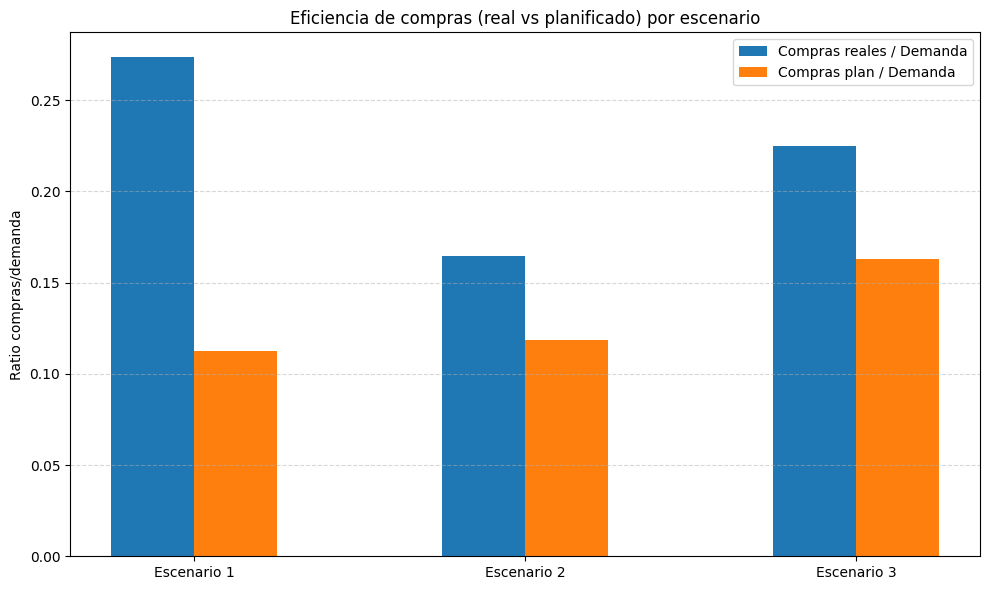

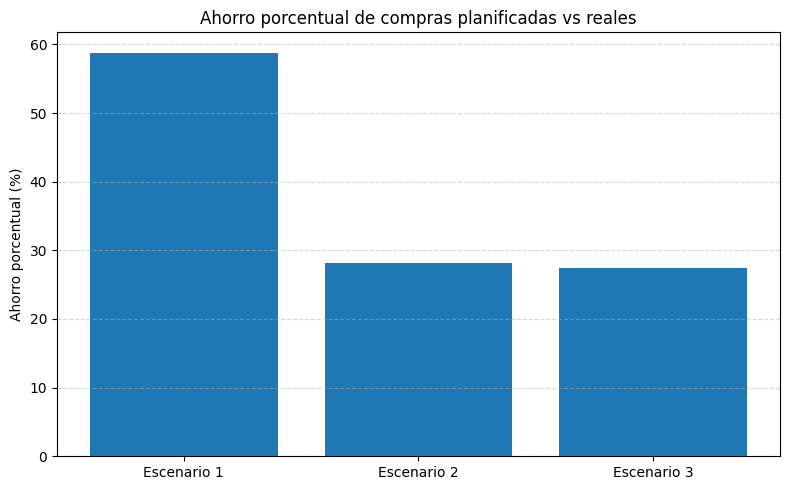

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0) Construir ventas_reales a partir del histórico (df_hist)
#    df_hist tiene: DATE_COL, PLATO_COL, TARGET_COL
# ============================================================

# Si ya definiste DATE_COL, PLATO_COL, TARGET_COL antes, aprovechamos eso
print("Columnas df_hist:", df_hist.columns.tolist())

ventas_reales = df_hist[[DATE_COL, PLATO_COL, TARGET_COL]].copy()
ventas_reales = ventas_reales.rename(columns={
    DATE_COL:  "fecha",
    PLATO_COL: "id_plato",
    TARGET_COL:"venta_real"
})
ventas_reales["fecha"] = pd.to_datetime(ventas_reales["fecha"], errors="coerce")

print("Preview ventas_reales:")
display(ventas_reales.head())

# ============================================================
# 1) Construir resumen_overstock por escenario
#    - demanda_real_total
#    - compra_real_total
#    - compra_plan_total
#    - ratio_real (compras/demanda real)
#    - ratio_plan (compras plan/demanda real)
#    - ahorro_porcentual (1 - plan/real)
# ============================================================

resumen_overstock = []

# Aseguramos que las fechas de compras estén en datetime
compras["fecha_registro"] = pd.to_datetime(compras["fecha_registro"], errors="coerce")

for idx, start_date in enumerate(SCENARIOS):
    esc = idx + 1

    # --- Forecast del escenario (para obtener end_date) ---
    forecast_plato = forecast_rf_scenarios[idx].copy()
    forecast_plato["fecha"] = pd.to_datetime(forecast_plato["fecha"], errors="coerce")
    end_date = forecast_plato["fecha"].max()

    print(f"\n=== Escenario {esc} ({start_date.date()} → {end_date.date()}) ===")

    # --- DEMANDA REAL (ventas) ---
    mask_v = (ventas_reales["fecha"] >= start_date) & (ventas_reales["fecha"] <= end_date)
    demanda_real_total = ventas_reales.loc[mask_v, "venta_real"].sum()

    # --- COMPRAS REALES ---
    mask_c = (compras["fecha_registro"] >= start_date) & (compras["fecha_registro"] <= end_date)
    compra_real_total = compras.loc[mask_c, "cantidad_entrada"].sum()

    # --- COMPRAS PLANIFICADAS (simulador s,S) ---
    plan = resultados_plan[idx].copy()
    plan["fecha_orden"] = pd.to_datetime(plan["fecha_orden"], errors="coerce")
    mask_p = (plan["fecha_orden"] >= start_date) & (plan["fecha_orden"] <= end_date)
    compra_plan_total = plan.loc[mask_p, "cantidad"].sum()

    # --- Ratios ---
    if demanda_real_total > 0:
        ratio_real = compra_real_total / demanda_real_total
        ratio_plan = compra_plan_total / demanda_real_total
    else:
        ratio_real = np.nan
        ratio_plan = np.nan

    # --- Ahorro porcentual de compras ---
    if compra_real_total > 0:
        ahorro_porcentual = (1 - (compra_plan_total / compra_real_total)) * 100
    else:
        ahorro_porcentual = np.nan

    print(f"  Demanda real total  : {demanda_real_total:0.2f}")
    print(f"  Compras reales total: {compra_real_total:0.2f}")
    print(f"  Compras plan total  : {compra_plan_total:0.2f}")
    print(f"  Ratio real (C/D)    : {ratio_real:0.3f}")
    print(f"  Ratio plan (C/D)    : {ratio_plan:0.3f}")
    print(f"  Ahorro % plan vs real: {ahorro_porcentual:0.2f} %")

    resumen_overstock.append({
        "escenario": esc,
        "start_date": start_date.date(),
        "end_date": end_date.date(),
        "demanda_real_total": demanda_real_total,
        "compra_real_total": compra_real_total,
        "compra_plan_total": compra_plan_total,
        "ratio_real": ratio_real,
        "ratio_plan": ratio_plan,
        "ahorro_porcentual": ahorro_porcentual
    })

resumen_overstock = pd.DataFrame(resumen_overstock)
print("\n=== RESUMEN OVERSTOCK (TOTAL POR ESCENARIO) ===")
display(resumen_overstock)

# Para los gráficos, usamos una etiqueta amigable
resumen_overstock["escenario_label"] = resumen_overstock["escenario"].apply(
    lambda x: f"Escenario {x}"
)

# ============================================================
# 2) GRÁFICO 1: Compras reales vs planificadas vs demanda real
# ============================================================

x = np.arange(len(resumen_overstock))  # posiciones en eje X
width = 0.25                           # ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width, resumen_overstock["demanda_real_total"], width, label="Demanda real")
plt.bar(x,         resumen_overstock["compra_real_total"], width, label="Compras reales")
plt.bar(x + width, resumen_overstock["compra_plan_total"], width, label="Compras planificadas")

plt.xticks(x, resumen_overstock["escenario_label"])
plt.ylabel("Cantidad total (unidades)")
plt.title("Demanda real vs Compras reales vs Compras planificadas por escenario")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================================
# 3) GRÁFICO 2: Ratio Compras / Demanda (real vs plan)
# ============================================================

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, resumen_overstock["ratio_real"], width, label="Compras reales / Demanda")
plt.bar(x + width/2, resumen_overstock["ratio_plan"], width, label="Compras plan / Demanda")

plt.xticks(x, resumen_overstock["escenario_label"])
plt.ylabel("Ratio compras/demanda")
plt.title("Eficiencia de compras (real vs planificado) por escenario")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================================
# 4) GRÁFICO 3: Ahorro porcentual en compras
# ============================================================

plt.figure(figsize=(8, 5))
plt.bar(x, resumen_overstock["ahorro_porcentual"])
plt.xticks(x, resumen_overstock["escenario_label"])
plt.ylabel("Ahorro porcentual (%)")
plt.title("Ahorro porcentual de compras planificadas vs reales")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
